# fMRI Analysis and Region-Based Activation Mapping with GLM and AAL Atlas

This notebook has the code for analyzing and visualizing fMRI data using General Linear Model (GLM) techniques and the AAL (Automated Anatomical Labeling) atlas. Below is an overview of the key steps:

1. **Library Imports and Environment Setup**:
   - Import necessary libraries for fMRI analysis and visualization.
   - Set up environment configurations for Neurodesk and FSL integration.

2. **Data Loading**:
   - Load anatomical and functional MRI data, along with any event-related data for the analysis.
   - Define paths for fMRI datasets, event files, and output directories.

3. **Design Matrix Construction**:
   - Build a design matrix for GLM analysis based on event timings and conditions, incorporating drift and motion regressors to improve model accuracy.

4. **GLM Analysis**:
   - Fit the GLM model to the fMRI data using the constructed design matrix.
   - Compute contrasts between specific experimental conditions (e.g., positive vs. negative stimuli).

5. **Region-Based Analysis with AAL Atlas**:
   - Load the AAL atlas to identify and isolate specific brain regions.
   - Highlight regions of interest by mapping them to activation data, focusing on areas involved in the study (e.g., Vermis, Olfactory areas).

6. **Visualization**:
   - Plot contrast and activation maps using the selected contrasts.
   - Display specific regions from the AAL atlas, using color-coded intensity levels to represent activation patterns.

7. **Results Interpretation**:
   - Summarize the main findings based on the GLM contrasts and regional activations.
   - Interpret the observed activation patterns in the context of the experimental design.

This notebook serves as a framework for conducting GLM-based fMRI analysis and regional mapping with the AAL atlas, suitable for investigating brain responses to specific stimuli or conditions.


In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ, get_json_from_file

####################
# Set DIPY_HOME for proper data downloads
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data"

#############################
# Loading fsl and freesurfer within Neurodesk
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Import all relevant libraries for analysis
##################
import fsl.wrappers
from fsl.wrappers import fslmaths, fast, bet, flirt
from fsl.wrappers.misc import fslroi

import mne
import mne_nirs
import nilearn
import nibabel as nib
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
from scipy.ndimage import zoom
import xml.etree.ElementTree as ET
import shutil
import glob
import requests
import urllib.request
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import openneuro
import ants
import os.path as op

from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
from nilearn.datasets import fetch_development_fmri, fetch_atlas_aal
from nilearn.image import resample_to_img, mean_img, load_img
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn import image, datasets, plotting, masking
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm.first_level.design_matrix import _make_drift
from IPython.display import display, HTML


In [2]:
%gui wx

In [3]:
#import useful paths : 

fmri_path = os.path.join('dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concat.nii.gz_smoothed-6mm.nii.gz')
events_path = os.path.join('dataset/ds000171/sub-control01/func/sub-control01_task-music_concat_run_events.tsv')
fmri_img = nib.load(fmri_path)
events = pd.read_csv(events_path, sep='\t')  
nbr_time_frame = fmri_img.shape[3]
print(os.path.abspath(fmri_path))
print(nbr_time_frame)

/data/NSSP_Mini_Project_1_Group_M/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concat.nii.gz_smoothed-6mm.nii.gz
315


## Matrix design 

In [4]:
events

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [5]:
# Get TR
TR = fmri_img.header.get_zooms()[3]
print(TR)

3.0


In [6]:
# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=int(TR),
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events)

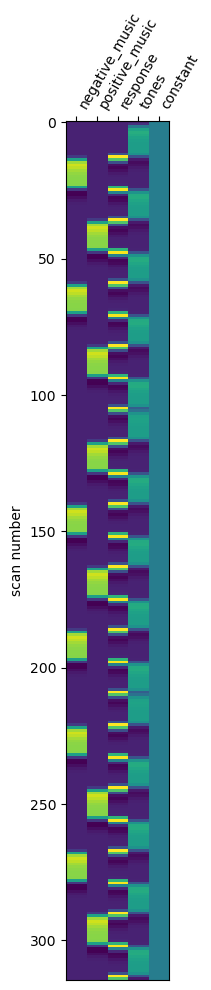

Regressor names: ['negative_music', 'positive_music', 'response', 'tones', 'constant']


In [7]:
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

# Get regressor names from the design matrix
regressor_names = fmri_glm.design_matrices_[0].columns.tolist()
print("Regressor names:", regressor_names)

945
Length of column_values: 315
Length of design_mat index: 315


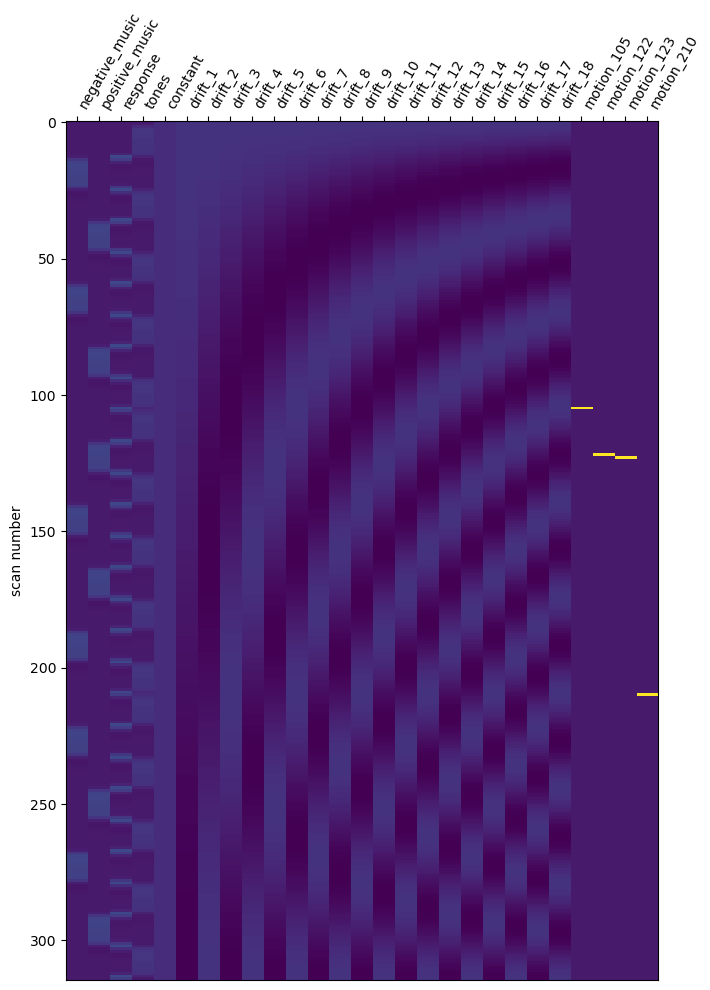

In [8]:
# Creation of the drift model:

x = int(nbr_time_frame*TR)
print(x)
column_values, column_names = _make_drift(drift_model='cosine', frame_times=np.asarray(list(range(0, x, int(TR)))), 
                                          order=3,  
                                          high_pass=0.01) # none for polynomial drift, 0.01 for cosine

design_mat = fmri_glm.design_matrices_[0]

# Check the lengths of column_values and design_mat before assignment
print("Length of column_values:", column_values.shape[0])
print("Length of design_mat index:", len(design_mat))

# If there is a mismatch, trim column_values to match the length of design_mat
if column_values.shape[0] > len(design_mat):
    column_values = column_values[:len(design_mat)]
elif column_values.shape[0] < len(design_mat):
    raise ValueError("column_values is shorter than design_mat, check input parameters.")

# Assign columns to the design matrix
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col


# Add motion regressors for specific timeframes (159 and 280)
motion_regressor_105 = np.zeros(len(design_mat))
motion_regressor_122 = np.zeros(len(design_mat))
motion_regressor_123 = np.zeros(len(design_mat))
motion_regressor_210 = np.zeros(len(design_mat))

motion_regressor_105[105] = 0.0001
motion_regressor_122[122] = 0.0001
motion_regressor_123[123] = 0.0001
motion_regressor_210[210] = 0.0001
design_mat['motion_105'] = motion_regressor_105
design_mat['motion_122'] = motion_regressor_122
design_mat['motion_123'] = motion_regressor_123
design_mat['motion_210'] = motion_regressor_210

# Plot the design matrix
plot_design_matrix(design_mat)
plt.show()


In [9]:
fit_glm = FirstLevelModel(t_r=int(TR),
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           #drift_order=2,
                           high_pass=0.01)



fit_glm.fit(fmri_img, design_matrices=[design_mat])

FirstLevelModel(hrf_model='spm', t_r=3)

In [10]:
# Get regressor names from the design matrix
regressor_names = fit_glm.design_matrices_[0].columns.tolist()
print("Regressor names:", regressor_names)
n_regressors=len(regressor_names)

# Generate the conditions dictionary
conditions = {
    regressor: np.eye(n_regressors)[i]
    for i, regressor in enumerate(regressor_names)
}

positive_minus_negative = conditions['positive_music']-conditions['negative_music']

Regressor names: ['negative_music', 'positive_music', 'response', 'tones', 'constant', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'drift_11', 'drift_12', 'drift_13', 'drift_14', 'drift_15', 'drift_16', 'drift_17', 'drift_18', 'motion_105', 'motion_122', 'motion_123', 'motion_210']


BETA MAP FOR negative_music


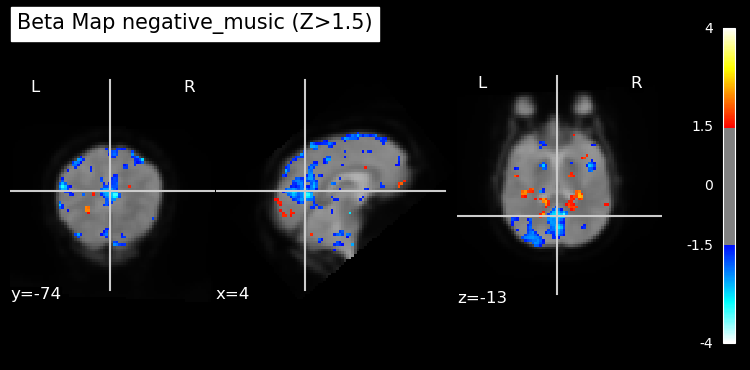

BETA MAP FOR positive_music


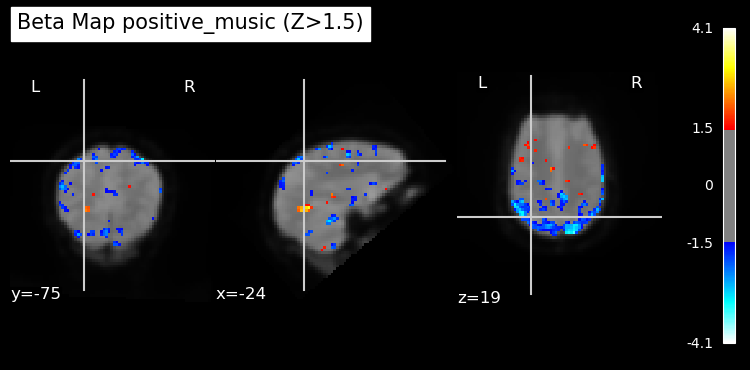

BETA MAP FOR response


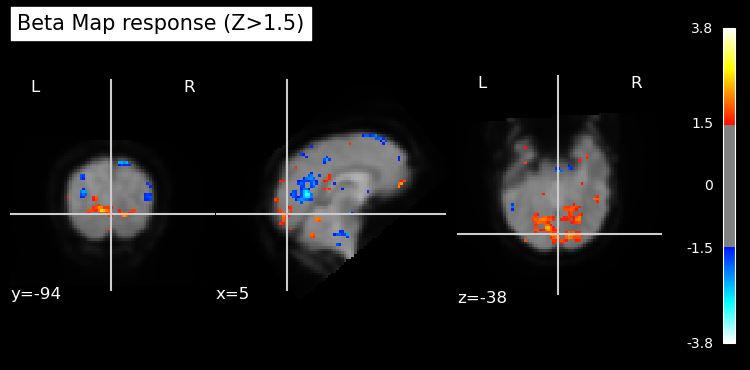

BETA MAP FOR tones


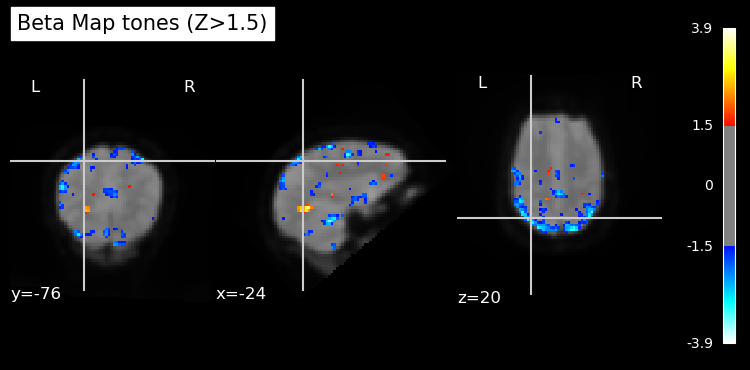

BETA MAP FOR constant


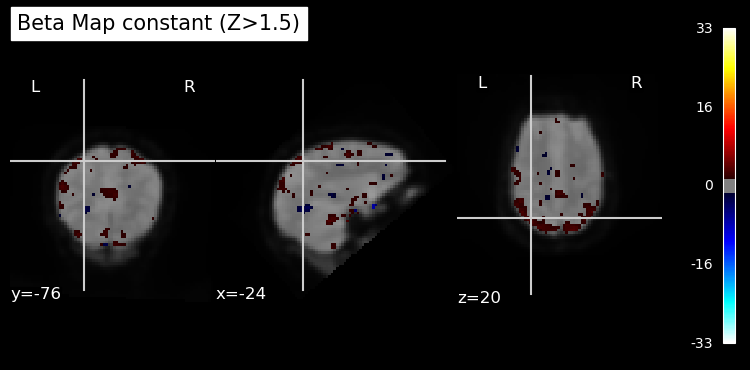

BETA MAP FOR drift_1


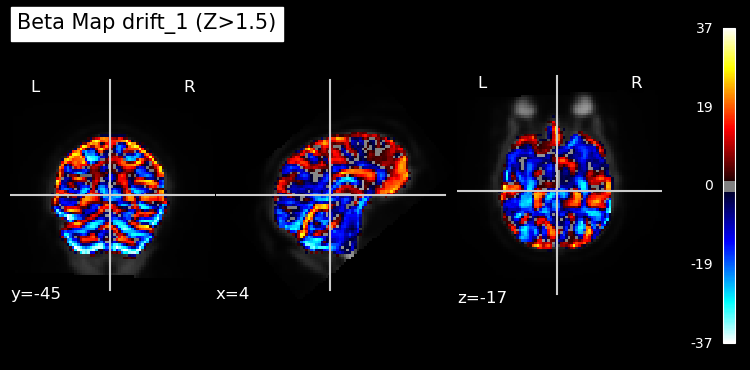

BETA MAP FOR drift_2


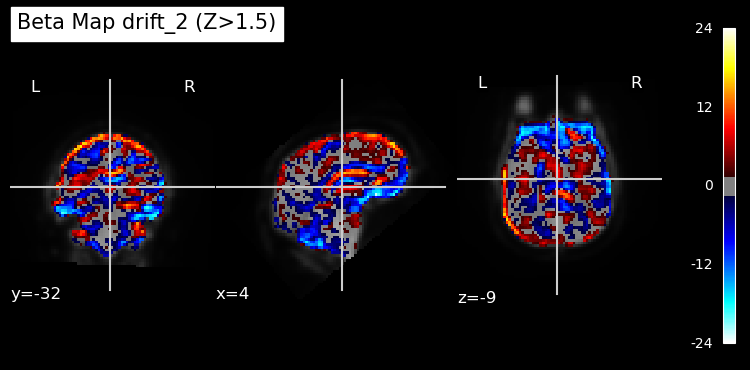

BETA MAP FOR drift_3


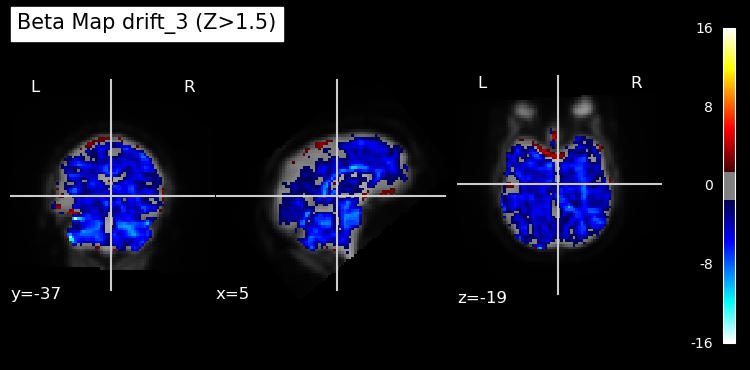

BETA MAP FOR drift_4


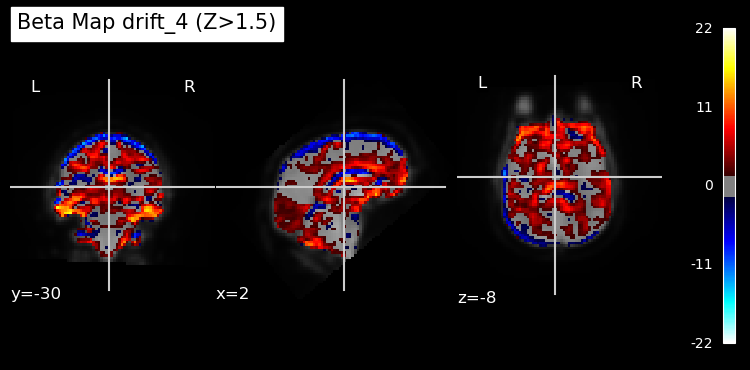

BETA MAP FOR drift_5


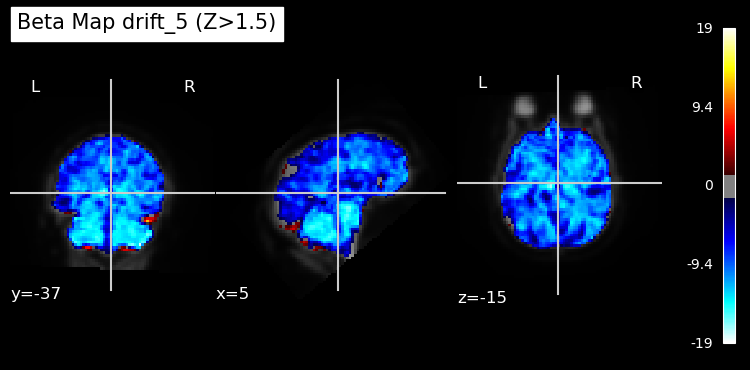

BETA MAP FOR drift_6


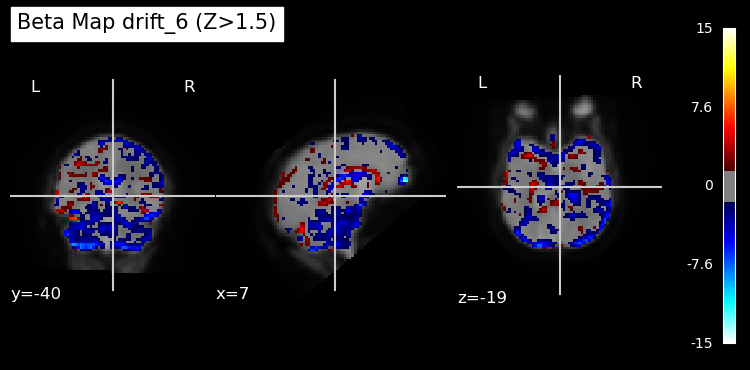

BETA MAP FOR drift_7


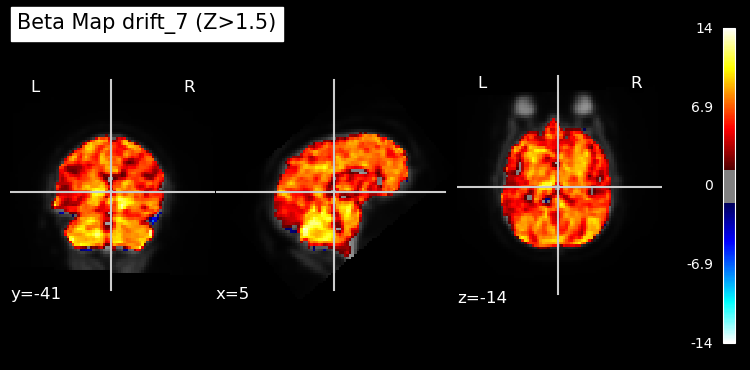

BETA MAP FOR drift_8


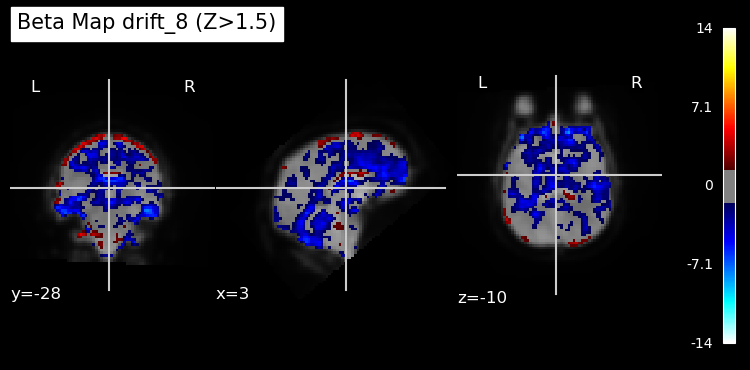

BETA MAP FOR drift_9


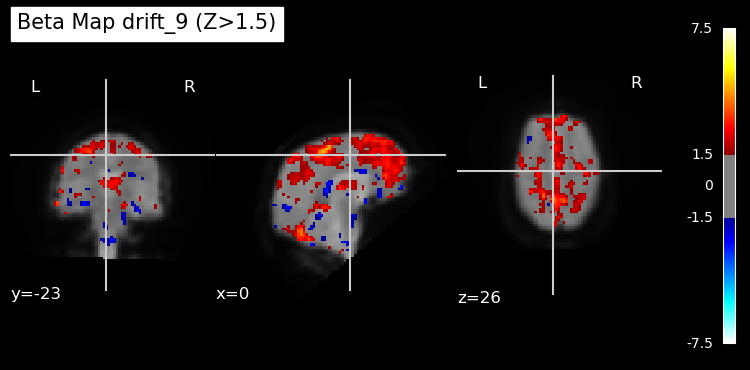

BETA MAP FOR drift_10


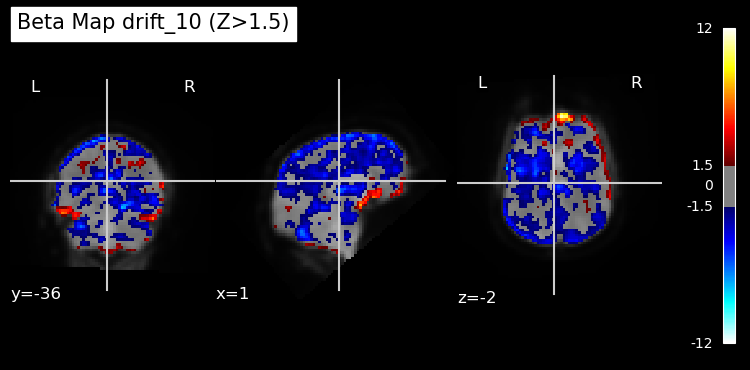

BETA MAP FOR drift_11


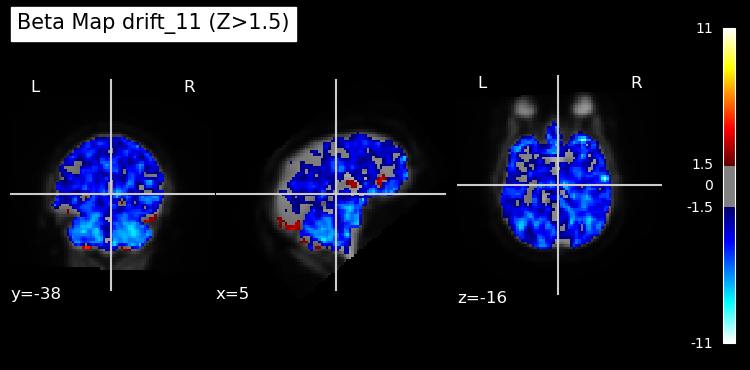

BETA MAP FOR drift_12


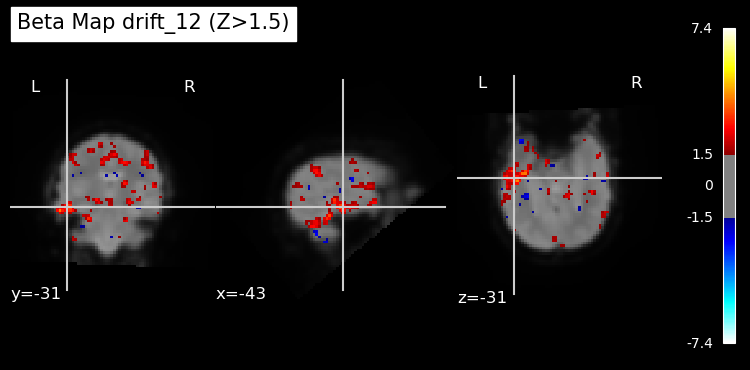

BETA MAP FOR drift_13


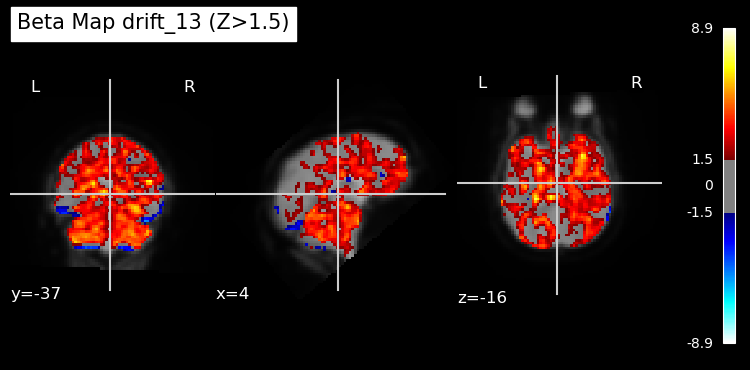

BETA MAP FOR drift_14


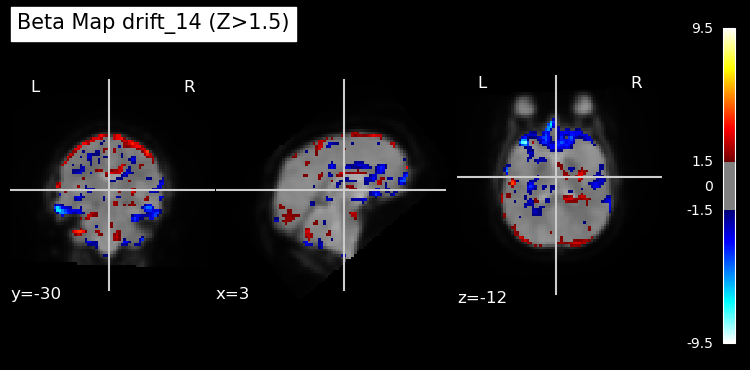

BETA MAP FOR drift_15


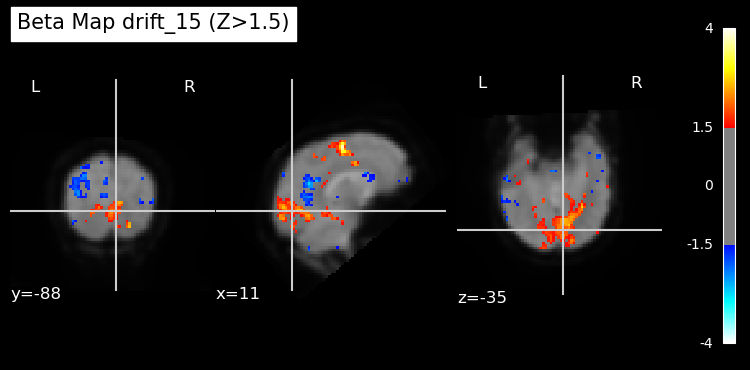

BETA MAP FOR drift_16


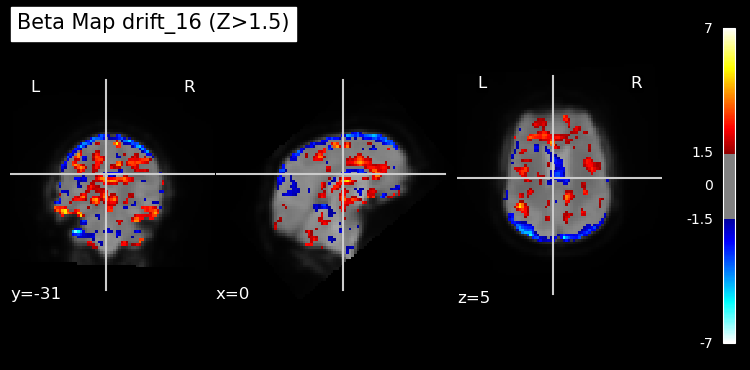

BETA MAP FOR drift_17


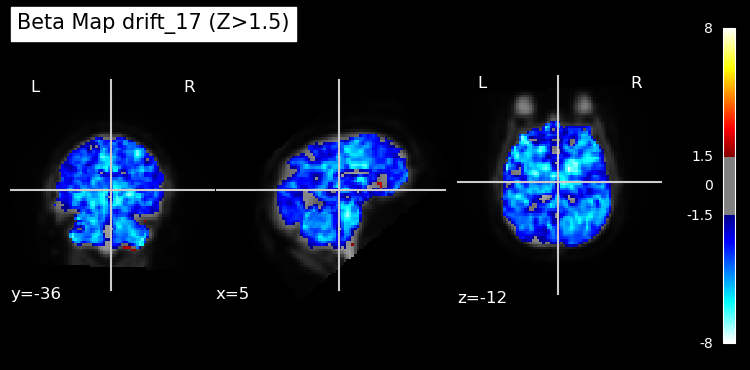

BETA MAP FOR drift_18


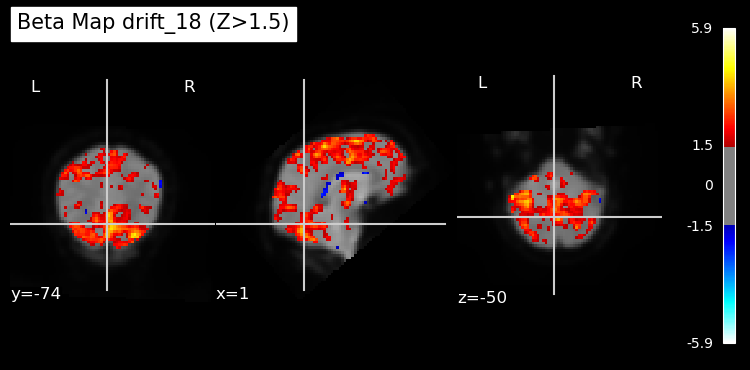

BETA MAP FOR motion_105


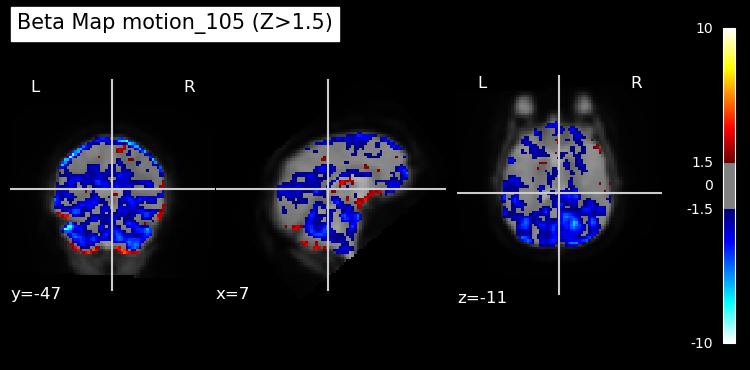

BETA MAP FOR motion_122


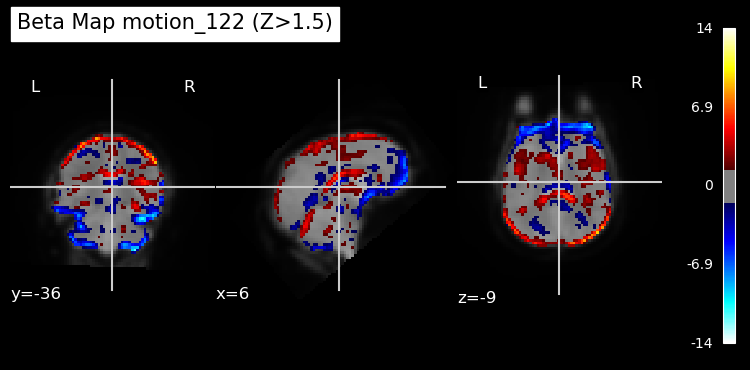

BETA MAP FOR motion_123


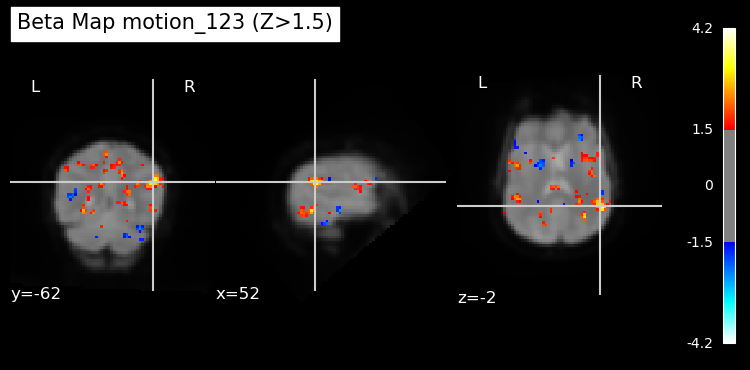

BETA MAP FOR motion_210


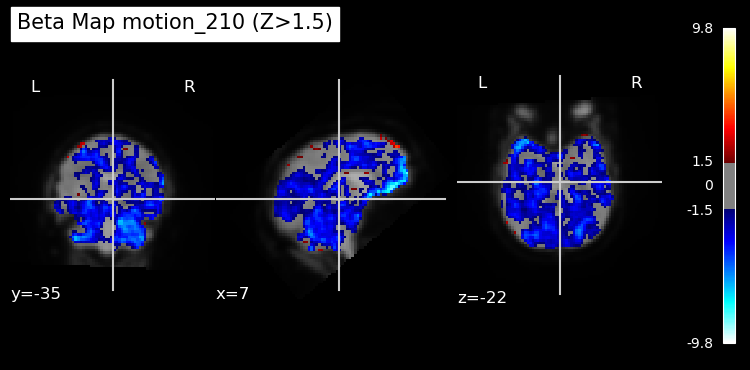

In [11]:
for condition in conditions :
    regressor=conditions[condition]
    print(f'BETA MAP FOR {condition}')
    #plot_contrast_matrix(regressor, design_matrix=design_mat) 
    beta_map = fit_glm.compute_contrast(regressor,
                                  output_type='z_score')

    nib.save(beta_map, f'beta_map_{condition}.nii.gz')
    mean_img_ = mean_img(fmri_img),
    plot_stat_map(beta_map, bg_img=mean_img_[0], threshold=1.5,
              display_mode='ortho', 
            #cut_coords=[-50, -40, -35, -20, -10, 0, 10, 20, 30, 40], black_bg=True,
              title=f'Beta Map {condition} (Z>1.5)')
    plt.show()

<Axes: label='conditions'>

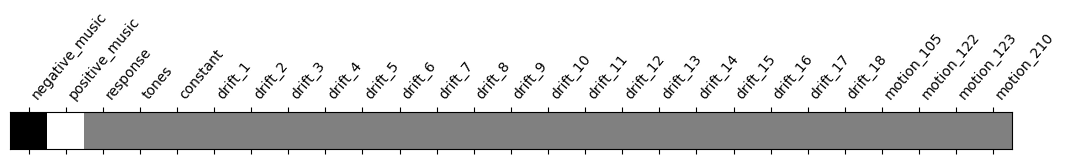

In [12]:
plot_contrast_matrix(positive_minus_negative, design_matrix=design_mat)  ####TODO ADD COLOR SCALE

In [13]:
z_map = fit_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

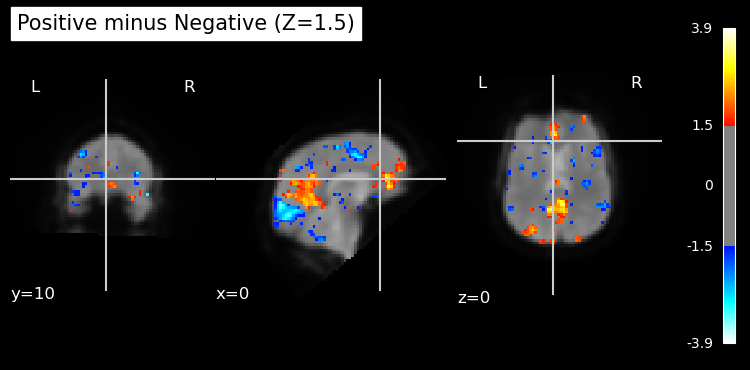

In [14]:
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=1.5,
              display_mode='ortho', cut_coords=[0, 10, 0], black_bg=True,
              title='Positive minus Negative (Z=1.5)')
plt.show()

In [15]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

Gtk-Message: 10:26:14.464: Failed to load module "canberra-gtk-module"

(ipykernel_launcher.py:5569): Gtk-CRITICAL **: 10:26:14.620: gtk_window_resize: assertion 'height > 0' failed


In [16]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('z_map_uncorrected.nii.gz')


(ipykernel_launcher.py:5569): Gdk-WARNING **: 10:26:15.859: gdkdrawable-x11.c:952 drawable is not a pixmap or window
10:26:15: Debug: ClientToScreen cannot work when toplevel window is not shown
10:26:15: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:5569): Gdk-WARNING **: 10:26:15.861: gdkdrawable-x11.c:952 drawable is not a pixmap or window
10:26:15: Debug: ClientToScreen cannot work when toplevel window is not shown
10:26:15: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:5569): Gdk-WARNING **: 10:26:15.864: gdkdrawable-x11.c:952 drawable is not a pixmap or window
10:26:15: Debug: ClientToScreen cannot work when toplevel window is not shown
10:26:15: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:5569): Gdk-WARNING **: 10:26:15.866: gdkdrawable-x11.c:952 drawable is not a pixmap or window
10:26:15: Debug: ClientToScreen cannot work when toplevel wi

In [17]:
# Get the list of regressor names
regressor_names = design_mat.columns.tolist()
n_regressors = len(regressor_names)

# Create a zero vector
contrast_vector = np.zeros(n_regressors)

# Set +1 for 'positive_music' and -1 for 'negative_music'
contrast_vector[regressor_names.index('positive_music')] = 1
contrast_vector[regressor_names.index('negative_music')] = -1

# Print the contrast vector
print("Contrast vector (positive_minus_negative):", contrast_vector)


Contrast vector (positive_minus_negative): [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [18]:
print("Design matrix columns:", design_mat.columns.tolist())

Design matrix columns: ['negative_music', 'positive_music', 'response', 'tones', 'constant', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'drift_11', 'drift_12', 'drift_13', 'drift_14', 'drift_15', 'drift_16', 'drift_17', 'drift_18', 'motion_105', 'motion_122', 'motion_123', 'motion_210']


In [19]:
# Assuming 'fit_glm' is your fitted GLM model from previous steps
z_map = fit_glm.compute_contrast(contrast_vector, output_type='z_score')

# Ensure z_map is 3D
if len(z_map.shape) == 4 and z_map.shape[-1] == 1:
    z_map = image.index_img(z_map, 0)

# Save the z-map (optional)

nib.save(z_map, 'positive_minus_negative_z_map.nii.gz')


## AAL 

In [20]:
# Load AAL atlas and extract indices and labels
aal_atlas = datasets.fetch_atlas_aal()
atlas_img = aal_atlas.maps
atlas_indices = range(1, len(aal_atlas.labels) + 1)  # Create indices starting from 1
atlas_labels = aal_atlas.labels

# Create dictionary mapping indices to labels
labels_dict = dict(zip(atlas_indices, atlas_labels))

# Example output
print(labels_dict)


{1: 'Precentral_L', 2: 'Precentral_R', 3: 'Frontal_Sup_L', 4: 'Frontal_Sup_R', 5: 'Frontal_Sup_Orb_L', 6: 'Frontal_Sup_Orb_R', 7: 'Frontal_Mid_L', 8: 'Frontal_Mid_R', 9: 'Frontal_Mid_Orb_L', 10: 'Frontal_Mid_Orb_R', 11: 'Frontal_Inf_Oper_L', 12: 'Frontal_Inf_Oper_R', 13: 'Frontal_Inf_Tri_L', 14: 'Frontal_Inf_Tri_R', 15: 'Frontal_Inf_Orb_L', 16: 'Frontal_Inf_Orb_R', 17: 'Rolandic_Oper_L', 18: 'Rolandic_Oper_R', 19: 'Supp_Motor_Area_L', 20: 'Supp_Motor_Area_R', 21: 'Olfactory_L', 22: 'Olfactory_R', 23: 'Frontal_Sup_Medial_L', 24: 'Frontal_Sup_Medial_R', 25: 'Frontal_Med_Orb_L', 26: 'Frontal_Med_Orb_R', 27: 'Rectus_L', 28: 'Rectus_R', 29: 'Insula_L', 30: 'Insula_R', 31: 'Cingulum_Ant_L', 32: 'Cingulum_Ant_R', 33: 'Cingulum_Mid_L', 34: 'Cingulum_Mid_R', 35: 'Cingulum_Post_L', 36: 'Cingulum_Post_R', 37: 'Hippocampus_L', 38: 'Hippocampus_R', 39: 'ParaHippocampal_L', 40: 'ParaHippocampal_R', 41: 'Amygdala_L', 42: 'Amygdala_R', 43: 'Calcarine_L', 44: 'Calcarine_R', 45: 'Cuneus_L', 46: 'Cuneus_

In [21]:
labels_dict = dict(zip(atlas_indices, atlas_labels))

In [22]:
# Get the MNI coordinates of the maximum z-score
z_data = z_map.get_fdata()
max_z = np.nanmax(z_data)
max_coords_voxel = np.unravel_index(np.nanargmax(z_data), z_data.shape)
max_coords_mni = nib.affines.apply_affine(z_map.affine, max_coords_voxel)

print(f"Maximum z-score: {max_z}")
print(f"Voxel coordinates: {max_coords_voxel}")
print(f"MNI coordinates: {max_coords_mni}")


Maximum z-score: 3.8743234381356455
Voxel coordinates: (49, 18, 35)
MNI coordinates: [ -19.4179434  -108.10522206  -22.5393508 ]


In [23]:
# Load your contrast map
contrast_img = nib.load('positive_minus_negative_z_map.nii.gz')

# Apply masking to extract the maximal activation region
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
time_series = masker.fit_transform(contrast_img)
mean_contrast_values = np.mean(time_series, axis=0)

# Identify the index of the region with the maximum contrast
max_region_index = np.argmax(mean_contrast_values)
max_region_name = atlas_labels[max_region_index]  # Retrieve the corresponding region name

# Output the results
if max_region_name == "Unknown":
    print("Region with maximal contrast is labeled as 'Unknown'. Please verify atlas alignment.")
else:
    print(f"The region with maximal contrast is: {max_region_name}")


The region with maximal contrast is: Vermis_7


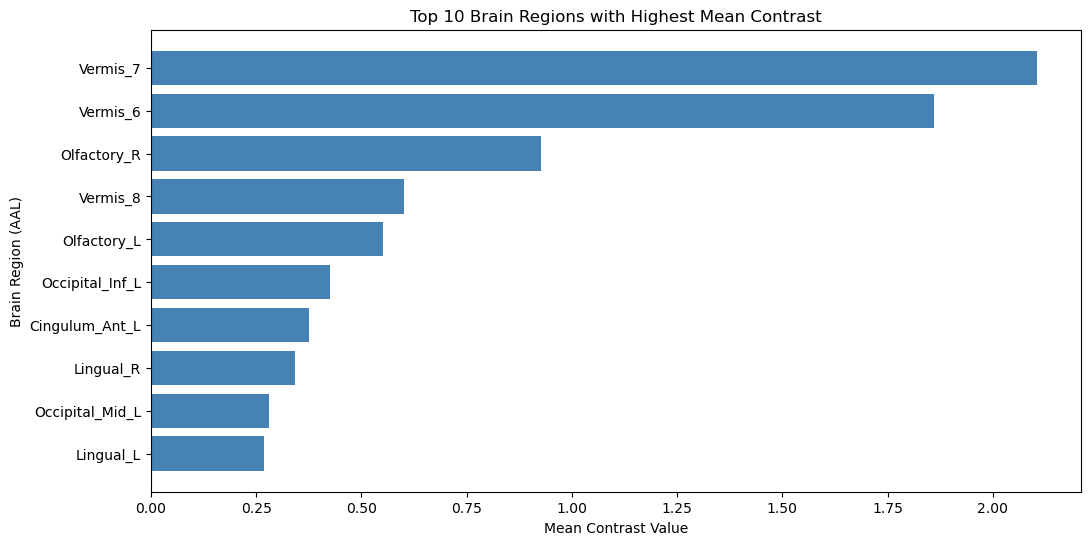

['Vermis_7' 'Vermis_6' 'Olfactory_R' 'Vermis_8' 'Olfactory_L'
 'Occipital_Inf_L' 'Cingulum_Ant_L' 'Lingual_R' 'Occipital_Mid_L'
 'Lingual_L']
[2.10393675 1.85954193 0.92654431 0.6016381  0.55078211 0.42627065
 0.37657089 0.34239394 0.28113227 0.26776347]


In [24]:
# Identify top regions
sorted_indices = np.argsort(mean_contrast_values)[::-1]
sorted_contrast_values = mean_contrast_values[sorted_indices]
sorted_labels = np.array(atlas_labels)[sorted_indices]

# Plot bar chart for the top 10 regions
plt.figure(figsize=(12, 6))
plt.barh(sorted_labels[:10], sorted_contrast_values[:10], color='steelblue')
plt.xlabel("Mean Contrast Value")
plt.ylabel("Brain Region (AAL)")
plt.title("Top 10 Brain Regions with Highest Mean Contrast")
plt.gca().invert_yaxis()
plt.show()
print(sorted_labels[:10])
print( sorted_contrast_values[:10])

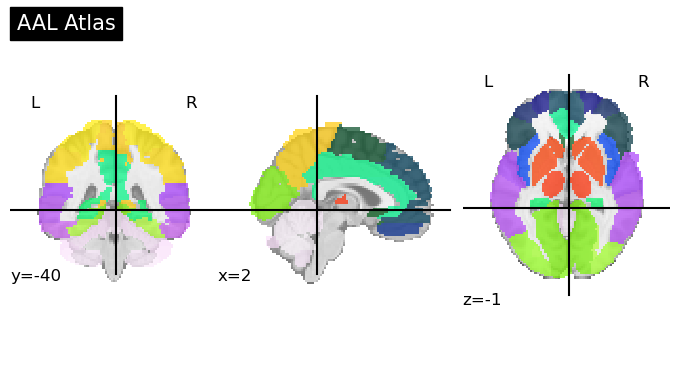

In [25]:
# Plot the atlas
plotting.plot_roi(atlas_img, title='AAL Atlas', display_mode='ortho')
plt.show()


In [26]:
# Load the atlas data
atlas_img = nib.load(aal_atlas.maps)
atlas_data = atlas_img.get_fdata()

In [27]:
# Print out all labels along with the unique IDs for clarity
unique_ids = np.unique(atlas_data)
for label, unique_id in zip(atlas_labels, unique_ids[1:]):  # Skip 0 (background)
    print(f"Region: {label}, ID: {unique_id}")

Region: Precentral_L, ID: 2001.0
Region: Precentral_R, ID: 2002.0
Region: Frontal_Sup_L, ID: 2101.0
Region: Frontal_Sup_R, ID: 2102.0
Region: Frontal_Sup_Orb_L, ID: 2111.0
Region: Frontal_Sup_Orb_R, ID: 2112.0
Region: Frontal_Mid_L, ID: 2201.0
Region: Frontal_Mid_R, ID: 2202.0
Region: Frontal_Mid_Orb_L, ID: 2211.0
Region: Frontal_Mid_Orb_R, ID: 2212.0
Region: Frontal_Inf_Oper_L, ID: 2301.0
Region: Frontal_Inf_Oper_R, ID: 2302.0
Region: Frontal_Inf_Tri_L, ID: 2311.0
Region: Frontal_Inf_Tri_R, ID: 2312.0
Region: Frontal_Inf_Orb_L, ID: 2321.0
Region: Frontal_Inf_Orb_R, ID: 2322.0
Region: Rolandic_Oper_L, ID: 2331.0
Region: Rolandic_Oper_R, ID: 2332.0
Region: Supp_Motor_Area_L, ID: 2401.0
Region: Supp_Motor_Area_R, ID: 2402.0
Region: Olfactory_L, ID: 2501.0
Region: Olfactory_R, ID: 2502.0
Region: Frontal_Sup_Medial_L, ID: 2601.0
Region: Frontal_Sup_Medial_R, ID: 2602.0
Region: Frontal_Med_Orb_L, ID: 2611.0
Region: Frontal_Med_Orb_R, ID: 2612.0
Region: Rectus_L, ID: 2701.0
Region: Rectus_R,

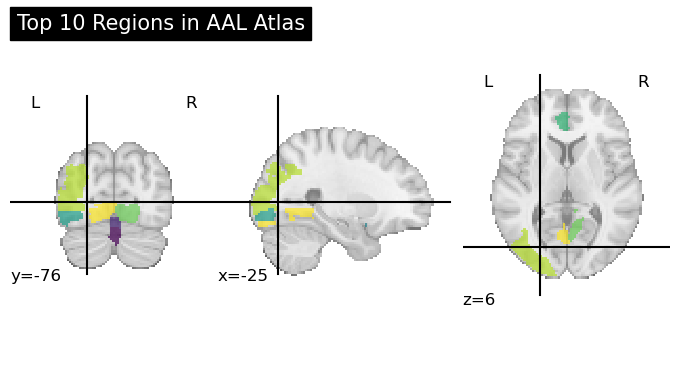

In [28]:
# Define the IDs for the top 10 regions you want to highlight
# Replace these with the desired region IDs based on the output list
top_10_region_ids = region_ids = [9140, 9130, 2502, 9150, 2501, 5301, 4001, 5022, 5201, 5021]

# Create a mask for the top 10 highlighted regions only
highlighted_data = np.zeros_like(atlas_data)

# Assign each selected region a unique intensity for visualization
for i, region_id in enumerate(top_10_region_ids, start=1):
    highlighted_data[atlas_data == region_id] = i

# Create a new Nifti image for the highlighted regions
highlighted_img = image.new_img_like(atlas_img, highlighted_data)

# Plot the highlighted regions with a color map
plotting.plot_roi(
    highlighted_img,
    title="Top 10 Regions in AAL Atlas",
    display_mode='ortho',
    cmap='viridis',  # Categorical color map to differentiate regions
    colorbar=False
)
plt.show()


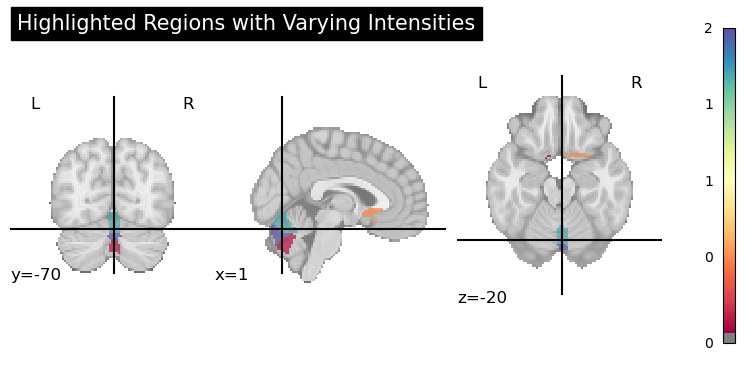

In [29]:
# Define the region IDs and their corresponding intensities
region_ids = [9140, 9130, 2502, 9150, 2501, 5301, 4001, 5022, 5201, 5021]
intensities = [2.10393675, 1.85954193, 0.92654431, 0.6016381,  0.55078211, 0.42627065,
 0.37657089, 0.34239394, 0.28113227, 0.26776347]  # Define intensities for each region

# Create a mask for the highlighted regions with different intensities
highlighted_data = np.zeros_like(atlas_data)

# Assign each region the specified intensity
for region_id, intensity in zip(region_ids, intensities):
    highlighted_data[atlas_data == region_id] = intensity

# Create a new Nifti image for the highlighted regions
highlighted_img = image.new_img_like(atlas_img, highlighted_data)

# Plot the highlighted regions with a color map
plotting.plot_roi(
    highlighted_img,
    title="Highlighted Regions with Varying Intensities",
    display_mode='ortho',
    cmap='Spectral',  # Color map to differentiate regions
    colorbar=True
)
plt.show()


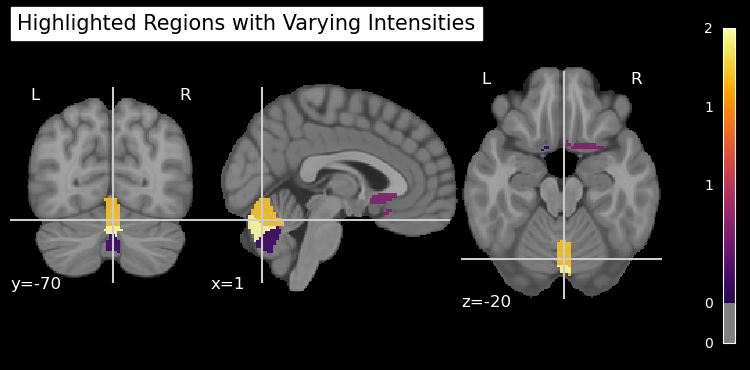

In [30]:
# Define the region IDs and their corresponding intensities
region_ids = [9140, 9130, 2502, 9150, 2501, 5301, 4001, 5022, 5201, 5021]
intensities = [2.10393675, 1.85954193, 0.92654431, 0.6016381, 0.55078211, 0.42627065,
               0.37657089, 0.34239394, 0.28113227, 0.26776347]  # Define intensities for each region

# Create a mask for the highlighted regions with different intensities
highlighted_data = np.zeros_like(atlas_data)

# Assign each region the specified intensity
for region_id, intensity in zip(region_ids, intensities):
    highlighted_data[atlas_data == region_id] = intensity

# Create a new Nifti image for the highlighted regions
highlighted_img = image.new_img_like(atlas_img, highlighted_data)

# Set the color map range for improved contrast
vmin = min(intensities)
vmax = max(intensities)

# Plot the highlighted regions with an appealing color map
plotting.plot_roi(
    highlighted_img,
    bg_img=datasets.load_mni152_template(),  # Adds anatomical context
    title="Highlighted Regions with Varying Intensities",
    display_mode='ortho',
    cmap='inferno',  # High-contrast, visually appealing color map
    colorbar=True,
    alpha=0.9,  # Transparency for non-highlighted areas
    vmin=vmin,  # Set color map minimum for clear scaling
    vmax=vmax   # Set color map maximum for clear scaling
)
plt.show()

